In [1]:
%matplotlib notebook
import orbipy as op
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from copy import copy
from scipy.interpolate import interp1d

In [2]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
stm_model = op.crtbp3_model(stm=True)

In [3]:
plotter = op.plotter.from_model(model, length_units='nd', velocity_units='nd/nd')
scaler = plotter.scaler

In [4]:
class Hyperbolic:
    def __init__(self):
        self.c2 = self.calc_c2()
        self.lam = self.calc_lam()
        self.omega = self.calc_omega()
        self.k1 = self.calc_k1()
        self.k2 = self.calc_k2()
        self.k3 = self.calc_k3()
        self.k4 = self.calc_k4()
        
    def p1(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p1_table(self, orbit):
        x = orbit['x'].values - model.L1
        vx = orbit['vx'].values
        y = orbit['y'].values
        vy = orbit['vy'].values
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) +\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def p2(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return ((self.k3*self.omega*x-self.k1*vy)/(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega) -\
                (self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/2
    
    def calc_vy(self, state):
        (x, y) = state[:2]
        x -= model.L1
        (vx, vy) = state[3:5]
        
        return (self.k3*self.omega*x+(self.k1*self.k4*self.lam+self.k2*self.k3*self.omega)*(self.k1*self.omega*y+self.k3*vx)/(self.k2*self.k3*self.lam-self.k1*self.k4*self.omega))/self.k1
        
    def calc_c2(self):
        r1 = np.abs(model.L1+model.mu)
        r2 = np.abs(model.L1+model.mu-1)
        
        return (1.-model.mu)/r1**3+model.mu/r2**3
    
    def calc_lam(self):
        return np.sqrt((self.c2-2+np.sqrt(9*self.c2**2-8*self.c2))/2)
    
    def calc_omega(self):
        return np.sqrt((-1.*self.c2+2+np.sqrt(9*self.c2**2-8*self.c2))/2)
        
    def calc_k1(self):
        return -2/(self.c2+3+self.lam**2)
    
    def calc_k2(self):
        return -2/(2*self.c2+1-self.lam**2)
    
    def calc_k3(self):
        return (self.omega*(self.c2-1+self.lam**2))/((self.c2-1)*(self.c2+3+self.lam**2))
    
    def calc_k4(self):
        return (self.lam*(-2*self.c2+3+self.lam**2))/((self.c2-1)*(-2*self.c2-1+self.lam**2))

In [5]:
def interactive_map(data, buffer):
    def onclick(event):
        if event.button == 3:
            ix, iy = event.xdata, event.ydata
            buffer.append([ix, iy])
            ax.plot(ix, iy, 'or')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(data['x0'], data['z0'], 'ob')
    ax.axis('equal')
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [6]:
with open('amp.pkl', 'rb') as fp:
    applicability = pickle.load(fp)

# Запустите ячейку и выберите начальную точку левой кнопкой мыши, выключите график

<IPython.core.display.Javascript object>


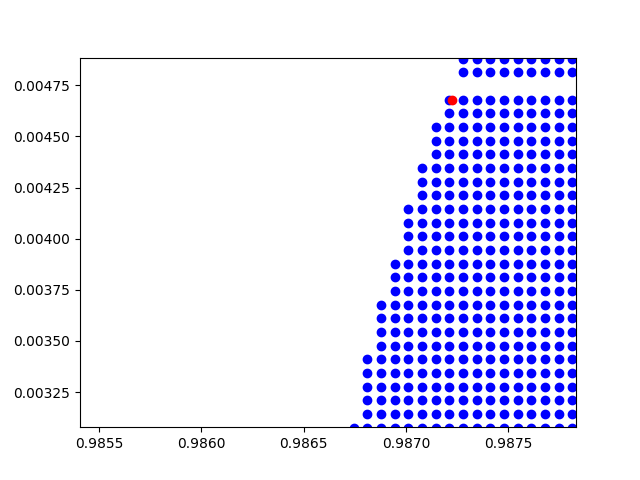

In [17]:
buffer = []
interactive_map(applicability, buffer)

In [7]:
# x0 = buffer[-1][0]
# z0 = buffer[-1][1]
x0 = 0.987225113782832
z0 = 0.004677764286120247
dx = scaler(-1000, 'km-nd')

x0 = 0.987225113782832
z0 = 0.004677764286120247

In [8]:
class EventP1(op.base_event):
    def __init__(self, value, terminal):
        self.hyp = Hyperbolic()
        super().__init__(value=value, terminal=terminal)
    
    def __call__(self, t, s):
        p1 = self.hyp.p1(s)
#         print(p1)
        return  p1 - self.value

## Холодный старт
Рассчитываются 4 орбиты методом плоскостей. Для каждой высчитвыается начальная скорость (vy0), максимальное (p1_max) и минимальное (p1_min) значение неустойчивой компоненты.

In [9]:
def prepare_step(x0, z0, dx):
    EL1_dist = 1.-model.mu - model.L1
    left = op.eventX(model.L1-EL1_dist)
    right = op.eventX(1.-model.mu)

    first_corr = op.border_correction(model, op.y_direction(), [left], [right])
    corr = op.border_correction(model, op.y_direction(), [left], [right])
    sk = op.simple_station_keeping(model, first_corr, corr)
    
    hyp = Hyperbolic()
    p1_min_values = []
    p1_max_values = []
    x0_values = []
    vy0_values = []
    
    for x in [x0+dx, x0+2*dx, x0+3*dx, x0+4*dx]:
        s0 = model.get_zero_state()
        s0[0] = x
        s0[2] = z0
        x0_values.append(x)
        df = sk.prop(0.0, s0, N=20)
        p1s = hyp.p1_table(df)
        p1_min_values.append(p1s.min())
        p1_max_values.append(p1s.max())
        vy0_values.append(df.iloc[0]['vy'])
    
    return x0_values, vy0_values , p1_min_values, p1_max_values

## Попытка расчета
В случае холодного старта (cold=True) вызовется вышеописанная функция. На каждом шаге икс-компонета начального положени КА смещается на dx. Для этой новой точки экстраполируются vy0, p1_min, p1_max. Далее, при помощи этих данных производится попытка расчета орбиты. В случае возникновения ошибки текущие данные возвращаются. Функцию можно перезапустить с момента ошибки с параметром cold=False, передав в качестве  x0_values_inp, vy0_values_inp, p1_min_values_inp, p1_max_values_inp данные, котрые вернулись после возникновения ошибки (пример ниже)

In [20]:
def run_calculations(x0, z0, dx, steps = 100, cold=True, x0_values_inp=None, vy0_values_inp=None, p1_min_values_inp=None, p1_max_values_inp=None):
    if cold:
        x0_values, vy0_values, p1_min_values, p1_max_values = prepare_step(x0, z0, dx)
    else:
        x0_values = copy(x0_values_inp)
        vy0_values = copy(vy0_values_inp)
        p1_min_values = copy(p1_min_values_inp)
        p1_max_values = copy(p1_max_values_inp)
 
    hyp = Hyperbolic()
    i = 0
    orbs = []
    
    while i < steps:
        print(i)
        p1_min_int = interp1d(x0_values[-4:], p1_min_values[-4:], kind='cubic', fill_value='extrapolate')
        p1_max_int = interp1d(x0_values[-4:], p1_max_values[-4:], kind='cubic', fill_value='extrapolate')
        vy0_int = interp1d(x0_values[-4:], vy0_values[-4:], kind='cubic', fill_value='extrapolate')

        x = x0_values[-1] + dx
        p1_min = p1_min_int([x])[0]
        p1_max = p1_max_int([x])[0]
#         import pdb; pdb.set_trace()
        vy = vy0_int([x])[0]
        print('P1 MIN:{}'.format(p1_min))
        print('P1 MAX:{}'.format(p1_max))
        s0 = model.get_zero_state()
        s0[0] = x
        s0[2] = z0
        s0[4] = vy
        
        p1_left = EventP1(value=p1_min, terminal=True)
        p1_right = EventP1(value=p1_max, terminal=True)
        corr = op.border_correction(model, op.y_direction(), [p1_left], [p1_right], dv0=1e-8)
        sk = op.simple_station_keeping(model, corr, corr)
        try:
            df = sk.prop(0.0, s0, N=18)
        except Exception as e:
            print(e)
            result = {'orbs': orbs,
                      'x0': x0_values,
                      'vy0': vy0_values,
                      'p1_min':p1_min_values,
                      'p1_max': p1_max_values,
                      'arr': sk.arr,
                      'debug': [x, vy, p1_min, p1_max]}
            return result
        
        orbs.append(df)
        x0_values.append(x)
        p1s = hyp.p1_table(df)
        p1_min_values.append(p1s.min())
        p1_max_values.append(p1s.max())
        vy0_values.append(df.iloc[0]['vy'])
        i+=1
    
    result = {'orbs': orbs,
              'x0': x0_values,
              'vy0': vy0_values,
              'p1_min':p1_min_values,
              'p1_max': p1_max_values}
    return result

In [15]:
res = run_calculations(x0, z0, dx)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0
P1 MIN:-0.007948837916323651
P1 MAX:0.0006609882876895412
> <ipython-input-14-4cdb8dfdeee1>(37)run_calculations()
-> try:
(Pdb) orbs
[]
(Pdb) c
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 
1
P1 MIN:-0.05928574813101227
P1 MAX:0.1083040846583817
> <ipython-input-14-4cdb8dfdeee1>(36)run_calculations()
-> import pdb; pdb.set_trace()
(Pdb) c
Simple station-keeping: Borders unreachable


Попытка расчета оказалась неуспешной. Выведем траекорию, которую удалось расчитать при помощи данного метода.

<IPython.core.display.Javascript object>


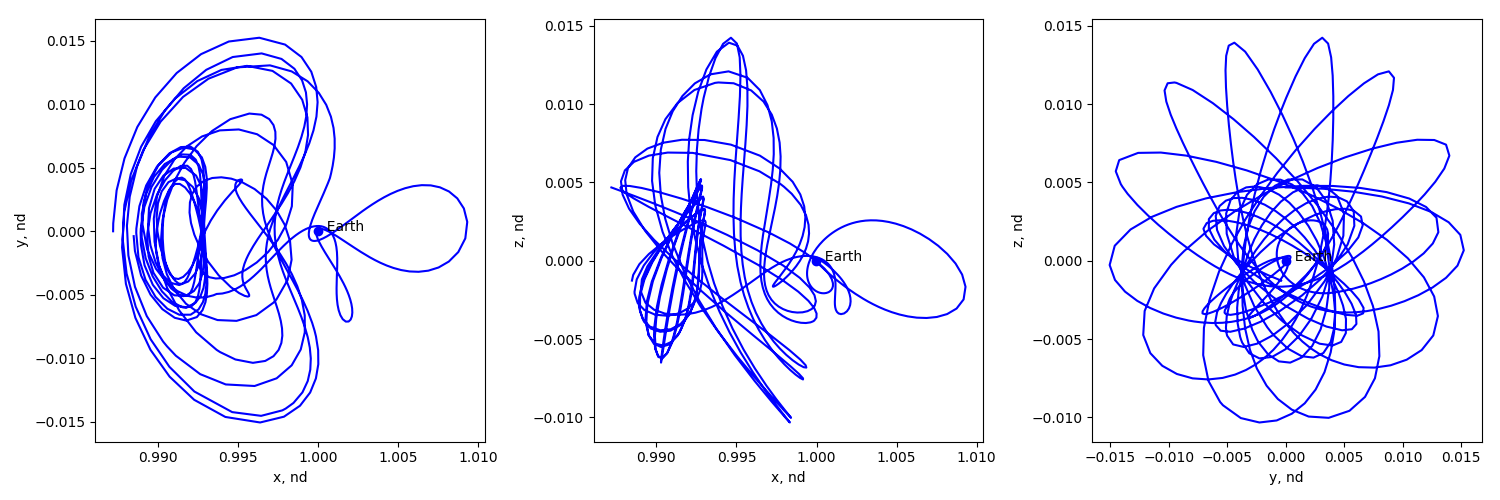

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb15a8b5080>,
      dtype=object)

In [13]:
ax = plotter.plot_proj(res['orbs'][0])
plotter.plot_proj(ax=ax, plottables=[plotter.m], marker='o')

# Пояснение
При помощи метода удалось расчитать только одну траекторию. Эта траектория является комбинацией орбит двух разных типов, что не является желаемым резултатом. Данный результат можно объяснить тем, что геометрические ограничения используемые для отыскания начальных условий, соответствующих орбите вокруг точки либрации зависят от времени. В исходной системе координат поверхности, определяеме этими геометрическими ограничениями передвигвигаются. Это приводит к тому, что в процессе работы алгоритм отыскивает коррекции скорости соответствующие разным орбитам. Также можно заметить, что получившиеся геометрические ограничения позволяют КА совершать витки вокруг Земли. Это поведения также является нежелаемым.

# Попытка №2
Выберем другие x0, z0

<IPython.core.display.Javascript object>


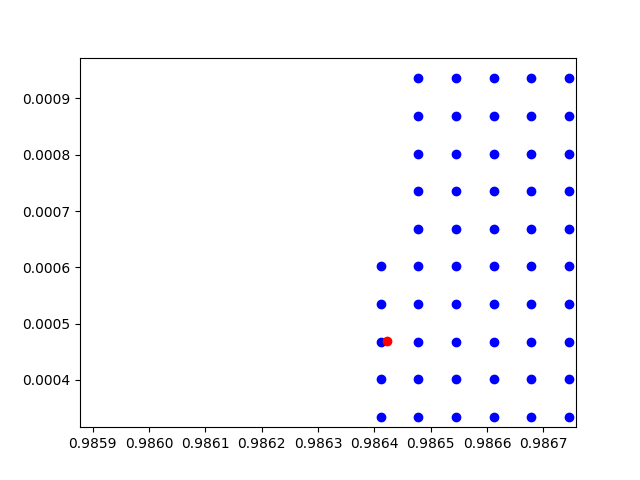

In [16]:
buffer = []
interactive_map(applicability, buffer)

In [17]:
x0 = buffer[-1][0]
z0 = buffer[-1][1]

x0 = 0.9864223576521489
z0 = 0.00046885003063325216

In [21]:
res = run_calculations(x0, z0, dx)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0
P1 MIN:-0.008250416400350315
P1 MAX:0.001151241031486316
Simple station-keeping: 0 1 2 3 4 5 f(a) and f(b) must have different signs


In [30]:
arr = []
for elem in res['arr']:
    arr.extend(elem)
arr = np.array(arr)
arr.shape

(296, 7)

Попытка также оказалось неуспешной. Удалось получить лишь одну траекторию, расчитаю на время 6Pi.

<IPython.core.display.Javascript object>


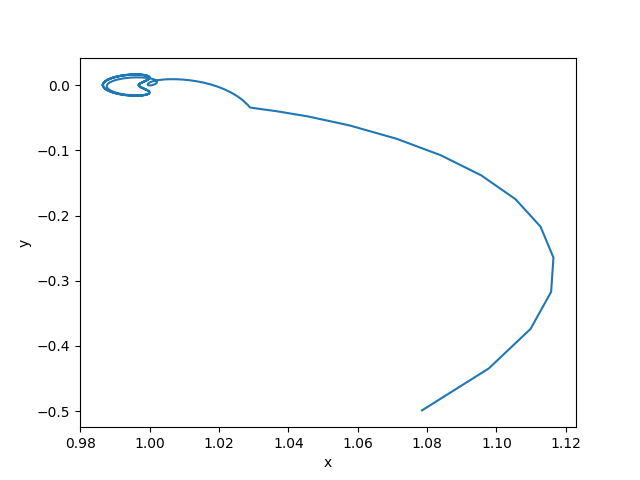

Text(0, 0.5, 'y')

In [35]:
plt.plot(arr[:,1], arr[:,2])
plt.xlabel('x')
plt.ylabel('y')